## Online Yemek Siparişi Geri Bildirim Tahmin Modeli (Online Food Ordering Feedback Prediction Model)

### Kütüphaneleri yükleme


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import warnings

warnings.filterwarnings('ignore')

### Veri seti yükleme ve ön işleme

In [43]:
df = pd.read_csv('OnlineFoodOrderCustomerData.csv')  # Veri setini yükleme
df.rename(columns={'Output': 'state_of_order'}, inplace=True)  # 'Output' sütununu 'state_of_order' olarak yeniden adlandırma
df = df.drop('Unnamed: 12', axis=1)  # 'Unnamed: 12' sütununu kaldırma
df['Monthly Income'] = df['Monthly Income'].str.replace('.', '', regex=False)  # 'Monthly Income' sütunundaki noktalama işaretlerini kaldırma
df['Educational Qualifications'] = df['Educational Qualifications'].str.replace('.', '', regex=False)  # 'Educational Qualifications' sütunundaki noktalama işaretlerini kaldırma
df = df.drop_duplicates()  # Tekrar eden satırları kaldırma

### Özellik ve hedef değişkenleri ayırma

In [44]:
X = df.drop(['Feedback'], axis=1)  # Geri bildirim sütununu hedef olarak ayırma
y_feedback = df['Feedback']

### 'Feedback' sütununu etiket kodlama ile sayısal değerlere dönüştürme

In [45]:
label_encoder = LabelEncoder()
y_feedback_encoded = label_encoder.fit_transform(y_feedback)

### Sayısal ve kategorik özellikleri belirleme

In [46]:
numeric_features = ['Age', 'Family size', 'Pin code', 'longitude', 'latitude']
categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Monthly Income', 'Educational Qualifications', 'state_of_order']

### Sayısal özellikleri ölçeklendirme

In [47]:
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X[numeric_features])

### Kategorik özellikleri one-hot encoding ile dönüştürme

In [48]:
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(X[categorical_features])

### Sayısal ve kategorik özellikleri birleştirme

In [49]:
X_processed = np.hstack((X_numeric, X_categorical))

### Eğitim ve test verilerine bölme

In [50]:
X_train, X_test, y_train_feedback, y_test_feedback = train_test_split(X_processed, y_feedback_encoded, test_size=0.2, random_state=42)

### Derin öğrenme modeli yapısı

In [51]:
def build_model(output_units, output_activation):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(output_units, activation=output_activation)
    ])
    # Modeli derleme
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy' if output_units == 1 and output_activation == 'sigmoid' else 'mse',
        metrics=['accuracy' if output_units == 1 and output_activation == 'sigmoid' else 'mae']
    )
    return model

### Online yemek siparişi geri bildirim tahmin modeli

In [52]:
feedback_model = build_model(1, 'sigmoid')
feedback_history = feedback_model.fit(
    X_train, y_train_feedback, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
6/6 [==============================] - 4s 105ms/step - loss: 0.9815 - accuracy: 0.4615 - val_loss: 0.6915 - val_accuracy: 0.3913
Epoch 2/100
6/6 [==============================] - 0s 24ms/step - loss: 0.8375 - accuracy: 0.5604 - val_loss: 0.6472 - val_accuracy: 0.7826
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 0.7411 - accuracy: 0.6209 - val_loss: 0.6176 - val_accuracy: 0.8261
Epoch 4/100
6/6 [==============================] - 0s 18ms/step - loss: 0.5770 - accuracy: 0.7418 - val_loss: 0.5924 - val_accuracy: 0.8043
Epoch 5/100
6/6 [==============================] - 0s 23ms/step - loss: 0.6067 - accuracy: 0.7033 - val_loss: 0.5742 - val_accuracy: 0.8696
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.5655 - accuracy: 0.7308 - val_loss: 0.5626 - val_accuracy: 0.8913
Epoch 7/100
6/6 [==============================] - 0s 21ms/step - loss: 0.5696 - accuracy: 0.7308 - val_loss: 0.5554 - val_accuracy: 0.8696
Epoch 8/100
6/6 [==

### Model performanslarını görselleştirme fonksiyonu

In [53]:
def plot_history(history, title):
    plt.figure(figsize=(14, 6))
    
    # Eğitim ve doğrulama performansını çizme
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim')
    plt.plot(history.history['val_accuracy'], label='Doğrulama')
    plt.title(f'{title} Model Performansı')
    plt.xlabel('epochs')
    plt.ylabel('Doğruluk')
    plt.legend()

    # Eğitim ve doğrulama kaybını çizme
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title(f'{title} Model Kaybı')
    plt.xlabel('epochs')
    plt.ylabel('Kayıp')
    plt.legend()

    plt.show()

### Model performanslarını görselleştirme

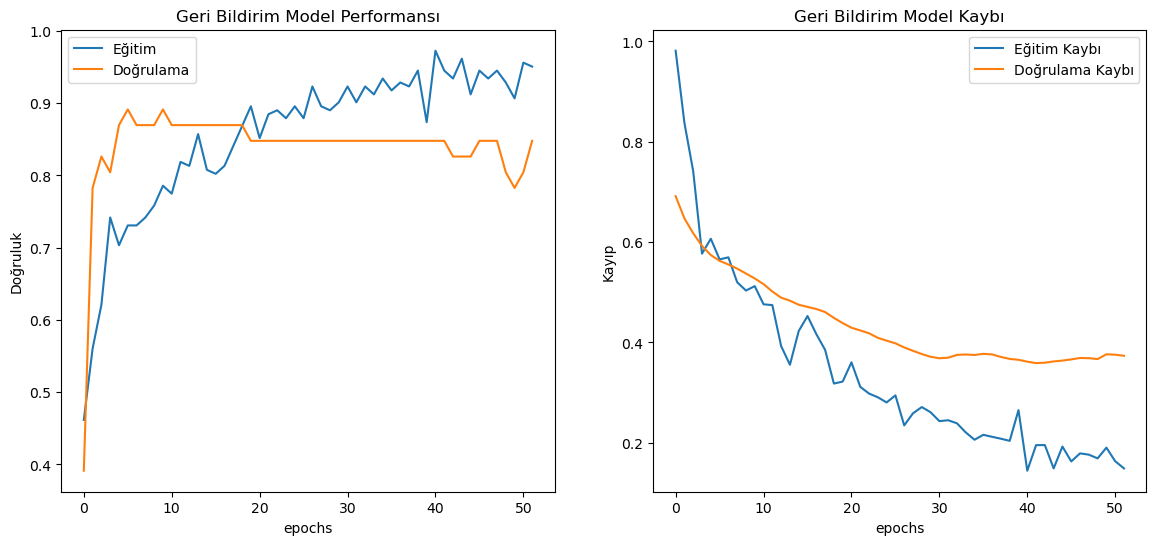

In [56]:
plot_history(feedback_history, 'Geri Bildirim')


### Performans yüzdelik doğruluk hesaplama fonksiyonu

In [57]:
def calculate_accuracy(y_true, y_pred, is_classification=False):
    if is_classification:
        accuracy = accuracy_score(y_true, y_pred)
        return accuracy * 100
    else:
        return None

### Geri bildirim tahmin sonuçları

In [58]:
y_pred_prob_feedback = feedback_model.predict(X_test)
y_pred_feedback_encoded = (y_pred_prob_feedback > 0.5).astype(int).flatten()

2/2 [==============================] - 0s 9ms/step


### Online yemek siparişi geri bildirim tahmin modelinin doğruluğu 

In [59]:
print(f"Online Yemek Siparişi Geri Bildirim Tahmin Modeli Doğruluğu: {calculate_accuracy(y_test_feedback, y_pred_feedback_encoded, is_classification=True):.2f}%")

Online Yemek Siparişi Geri Bildirim Tahmin Modeli Doğruluğu: 91.23%


### Etiket kodlamadan orijinal etiketlere dönüştürme

In [60]:
y_pred_feedback = label_encoder.inverse_transform(y_pred_feedback_encoded)
y_test_feedback_original = label_encoder.inverse_transform(y_test_feedback)

### Sınıflandırma raporu

In [61]:
print(classification_report(y_test_feedback, y_pred_feedback_encoded, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   Negative        0.67      0.57      0.62         7
    Positive       0.94      0.96      0.95        50

    accuracy                           0.91        57
   macro avg       0.80      0.77      0.78        57
weighted avg       0.91      0.91      0.91        57



### Gerçek ve tahmin edilen geri bildirimler

In [62]:
feedback_results = pd.DataFrame({
    'Gerçek Geri Bildirim': y_test_feedback_original,
    'Tahmin Edilen Geri Bildirim': y_pred_feedback
})

feedback_results_styled = feedback_results.head(20).style.set_properties(**{'text-align': 'left'}).set_table_styles({
    'Tahmin Edilen Geri Bildirim': [{'selector': 'td', 'props': [('padding-left', '20px')]}]
})

feedback_results_styled

,Gerçek Geri Bildirim,Tahmin Edilen Geri Bildirim
0,Positive,Positive
1,Positive,Positive
2,Positive,Positive
3,Negative,Positive
4,Positive,Positive
5,Positive,Positive
6,Positive,Positive
7,Positive,Positive
8,Positive,Positive
9,Negative,Negative
